In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.56)
import gc

import os, sys, random, math

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from bayes_opt import BayesianOptimization
import lightgbm as lgb

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
%%time

print('Loading data...')

train = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/train.csv', index_col='txkey')
print('\tSuccessfully loaded train_identity!')

test = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/test.csv', index_col='txkey')
print('\tSuccessfully loaded test_identity!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded test_identity!
Data was successfully loaded!

Wall time: 4.88 s


In [4]:
train['flbmk'] = train['flbmk'].fillna('Nan')
train['flg_3dsmk'] = train['flg_3dsmk'].fillna('Nan')

test['flbmk'] = test['flbmk'].fillna('Nan')
test['flg_3dsmk'] = test['flg_3dsmk'].fillna('Nan')

In [5]:
check_null_train = train.isnull().sum()
check_null_train[check_null_train>0].sort_values(ascending=False)

Series([], dtype: int64)

In [6]:
check_null_test = test.isnull().sum()
check_null_test[check_null_test>0].sort_values(ascending=False)

Series([], dtype: int64)

In [7]:
def data_split(dataframe):
    
    dataframe['ecfg'] = dataframe['ecfg'].map({'Y':1, 'N':0})
    dataframe['ovrlt'] = dataframe['ovrlt'].map({'Y':1, 'N':0})
    dataframe['flbmk'] = dataframe['flbmk'].map({'Y':2, 'N':1, 'Nan':0})
    dataframe['flg_3dsmk'] = dataframe['flg_3dsmk'].map({'Y':2, 'N':1, 'Nan':0})
    dataframe['insfg'] = dataframe['insfg'].map({'Y':1, 'N':0})
    dataframe['locdt_M'] = dataframe['locdt'].map({1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,
                                                   16:1,17:1,18:1,19:1,20:1,21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1,31:1,
                                                   32:2,33:2,34:2,35:2,36:2,37:2,38:2,39:2,40:2,41:2,42:2,43:2,44:2,45:2,
                                                   46:2,47:2,48:2,49:2,50:2,51:2,52:2,53:2,54:2,55:2,56:2,57:2,58:2,59:2,60:2,61:2,
                                                   62:3,63:3,64:3,65:3,66:3,67:3,68:3,69:3,70:3,71:3,72:3,73:3,74:3,75:3,
                                                   76:3,77:3,78:3,79:3,80:3,81:3,82:3,83:3,84:3,85:3,86:3,87:3,88:3,89:3,90:3,91:3,92:3,
                                                   93:4,94:4,95:4,96:4,97:4,98:4,99:4,100:4,101:4,102:4,103:4,104:4,105:4,106:4,107:4,
                                                   108:4,109:4,110:4,111:4,112:4,113:4,114:4,115:4,116:4,117:4,118:4,119:4,120:4})
    gc.collect()
    
    return dataframe

In [8]:
train = data_split(train)
test = data_split(test)

In [9]:
train['txn_info'] = train['flg_3dsmk'].astype(str)+train['flbmk'].astype(str)+train['stscd'].astype(str)+train['ovrlt'].astype(str)
test['txn_info'] = test['flg_3dsmk'].astype(str)+test['flbmk'].astype(str)+test['stscd'].astype(str)+test['ovrlt'].astype(str)

In [10]:
RiskCountry = [104, 75]
train['HighRiskCountry'] = train['stocn'].apply(lambda x: 1 if x in RiskCountry else 0)
test['HighRiskCountry'] = test['stocn'].apply(lambda x: 1 if x in RiskCountry else 0)

In [11]:
RiskCurrency = [60, 61]
train['HighRiskCurrency'] = train['csmcu'].apply(lambda x: 1 if x in RiskCurrency else 0)
test['HighRiskCurrency'] = test['csmcu'].apply(lambda x: 1 if x in RiskCurrency else 0)

In [12]:
train['HighRiskFlag'] = train['HighRiskCountry'].astype(str)+train['HighRiskCurrency'].astype(str)
test['HighRiskFlag'] = test['HighRiskCountry'].astype(str)+test['HighRiskCurrency'].astype(str)

In [13]:
train['conam_decimal'] = ((train['conam'] - train['conam'].astype(int)) * 1000).astype(int)
test['conam_decimal'] = ((test['conam'] - test['conam'].astype(int)) * 1000).astype(int)

In [14]:
train['HighRiskLowerAmount'] = 0
test['HighRiskLowerAmount'] = 0

train['HighRiskLowerAmount'] = train['conam'] < 201
test['HighRiskLowerAmount'] = test['conam'] < 201

train['HighRiskLowerAmount'] = train['HighRiskLowerAmount'].map({True:1, False:0})
test['HighRiskLowerAmount'] = test['HighRiskLowerAmount'].map({True:1, False:0})

In [15]:
train['HighRiskHigherAmount'] = 0
test['HighRiskHigherAmount'] = 0

train['HighRiskHigherAmount'] = train['conam'] > 999
test['HighRiskHigherAmount'] = test['conam'] > 999

train['HighRiskHigherAmount'] = train['HighRiskHigherAmount'].map({True:1, False:0})
test['HighRiskHigherAmount'] = test['HighRiskHigherAmount'].map({True:1, False:0})

In [16]:
train['loct_hour'] = train['loctm']//10000
test['loct_hour'] = test['loctm']//10000

In [17]:
for col in ['locdt','txn_info']: #'locdt_M'
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)

In [18]:
# simply aggregations no logic
train['conam_to_mean_cano'] = train['conam'] / train.groupby(['cano'])['conam'].transform('mean')
train['conam_to_mean_bacno'] = train['conam'] / train.groupby(['bacno'])['conam'].transform('mean')
test['conam_to_mean_cano'] = test['conam'] / test.groupby(['cano'])['conam'].transform('mean')
test['conam_to_mean_bacno'] = test['conam'] / test.groupby(['bacno'])['conam'].transform('mean')

train['conam_to_std_cano'] = train['conam'] / train.groupby(['cano'])['conam'].transform('std')
train['conam_to_std_bacno'] = train['conam'] / train.groupby(['bacno'])['conam'].transform('std')
test['conam_to_std_cano'] = test['conam'] / test.groupby(['cano'])['conam'].transform('std')
test['conam_to_std_bacno'] = test['conam'] / test.groupby(['bacno'])['conam'].transform('std')

train['conam_to_mean_mchno'] = train['conam'] / train.groupby(['mchno'])['conam'].transform('mean')
train['conam_to_mean_mcc'] = train['conam'] / train.groupby(['mcc'])['conam'].transform('mean')
train['conam_to_mean_hcefg'] = train['conam'] / train.groupby(['hcefg'])['conam'].transform('mean')
test['conam_to_mean_mchno'] = test['conam'] / test.groupby(['mchno'])['conam'].transform('mean')
test['conam_to_mean_mcc'] = test['conam'] / test.groupby(['mcc'])['conam'].transform('mean')
test['conam_to_mean_hcefg'] = test['conam'] / test.groupby(['hcefg'])['conam'].transform('mean')

train['conam_to_std_mchno'] = train['conam'] / train.groupby(['mchno'])['conam'].transform('std')
train['conam_to_std_mcc'] = train['conam'] / train.groupby(['mcc'])['conam'].transform('std')
train['conam_to_std_hcefg'] = train['conam'] / train.groupby(['hcefg'])['conam'].transform('std')
test['conam_to_std_mchno'] = test['conam'] / test.groupby(['mchno'])['conam'].transform('std')
test['conam_to_std_mcc'] = test['conam'] / test.groupby(['mcc'])['conam'].transform('std')
test['conam_to_std_hcefg'] = test['conam'] / test.groupby(['hcefg'])['conam'].transform('std')

train['conam_to_mean_acqic'] = train['conam'] / train.groupby(['acqic'])['conam'].transform('mean')
test['conam_to_mean_acqic'] = test['conam'] / test.groupby(['acqic'])['conam'].transform('mean')

train['conam_to_std_acqic'] = train['conam'] / train.groupby(['acqic'])['conam'].transform('std')
test['conam_to_std_acqic'] = test['conam'] / test.groupby(['acqic'])['conam'].transform('std')

In [19]:
# check amount
train['conam_check'] = np.where(train['conam'].isin(test['conam']), 1, 0)
test['conam_check']  = np.where(test['conam'].isin(train['conam']), 1, 0)

In [20]:
train['uid'] = train['cano'].astype(str)+'_'+train['bacno'].astype(str)
test['uid'] = test['cano'].astype(str)+'_'+test['bacno'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['acqic'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['acqic'].astype(str)

train['uid3'] = train['uid2'].astype(str)+'_'+train['mchno'].astype(str)+'_'+train['mcc'].astype(str)
test['uid3'] = test['uid2'].astype(str)+'_'+test['mchno'].astype(str)+'_'+test['mcc'].astype(str)

train['uid4'] = train['uid'].astype(str)+'_'+train['stocn'].astype(str)+'_'+train['scity'].astype(str)+'_'+train['csmcu'].astype(str)
test['uid4'] = test['uid'].astype(str)+'_'+test['stocn'].astype(str)+'_'+test['scity'].astype(str)+'_'+test['csmcu'].astype(str)
#train['uid4'] = train['uid'].astype(str)+'_'+train['stocn'].astype(str)+'_'+train['csmcu'].astype(str)
#test['uid4'] = test['uid'].astype(str)+'_'+test['stocn'].astype(str)+'_'+test['csmcu'].astype(str)

In [21]:
periods = ['locdt','txn_info'] #'locdt_M'
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [22]:
uid_cols = ['uid','uid2','uid3','uid4']

for col in uid_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_conam_'+agg_type
        temp_df = pd.concat([train[[col, 'conam']], test[[col,'conam']]])
        temp_df = temp_df.groupby([col])['conam'].agg([agg_type]).reset_index().rename(
                                                  columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [23]:
for feature in ['cano', 'bacno', 'acqic', 'mchno', 'mcc']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [24]:
# features interaction
for feature in ['cano__bacno', 'stocn__scity', 'csmcu__etymd', 'ecfg__contp', 'mchno__mcc',
                'ecfg__etymd', 'acqic__hcefg', 'mchno__hcefg', 'insfg__iterm', 'stscd__etymd']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [25]:
for col in ['contp','etymd','hcefg']:
    temp_dict = train.groupby([col])['fraud_ind'].agg(['mean']).reset_index().rename(
                                                           columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train[col+'_target_mean'] = train[col].map(temp_dict)
    test[col+'_target_mean']  = test[col].map(temp_dict)

In [26]:
# frequency encodeing 
fq_cols = ['cano', 'bacno', 'mchno', 'mcc', 'acqic',
           'stocn', 'scity', 'csmcu', 'txn_info',
           'contp','etymd', 'hcefg', 'HighRiskFlag',
           'uid', 'uid2', 'uid3']

for col in fq_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [27]:
for feature in ['HighRiskHigherAmount__etymd', 'HighRiskLowerAmount__etymd']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [ ]:
#train['txn_time_info'] = train['locdt'].astype(str)+'_'+train['loct_hour'].astype(str)+'_'+train['cano'].astype(str)+'_'+train['bacno'].astype(str)
#test['txn_time_info'] = test['locdt'].astype(str)+'_'+test['loct_hour'].astype(str)+'_'+test['cano'].astype(str)+'_'+test['bacno'].astype(str)

In [ ]:
#for feature in ['txn_time_info']:
#    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
#    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

In [28]:
# drop noise data
cols_to_drop = ['loctm','uid','uid2','uid3','uid4',
                'txn_info','txn_info_total','HighRiskCountry','HighRiskCurrency']

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

9 features are going to be dropped for being useless


In [29]:
for col in train.columns:
    if train[col].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = lbl.transform(list(train[col].astype(str).values))
        test[col] = lbl.transform(list(test[col].astype(str).values))

In [30]:
SEED = 42
seed_everything(SEED)

In [31]:
y = train.sort_values('locdt')['fraud_ind']
X = train.sort_values('locdt').drop(['fraud_ind','locdt'], axis=1)

X_test = test.drop('locdt', axis=1)

print ("Size of y_train data : {}" .format(y.shape))
print ("Size of X_train data : {}" .format(X.shape))
print ("Size of test data : {}" .format(X_test.shape))

del train, test
gc.collect()

Size of y_train data : (1521787,)
Size of X_train data : (1521787, 85)
Size of test data : (421665, 85)


75

In [32]:
# untuning params
params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'metric': 'auc',
          'learning_rate': 0.007,
          'num_leaves': 2**8,
          'max_depth': -1,
          'tree_learner':'serial',
          'colsample_bytree': 0.5,
          'subsample_freq':1,
          'subsample':0.7,
          'n_estimators':10000,
          'min_data_in_leaf': 106,
          'max_bin':255,
          'verbosity': -1,
          'seed': SEED,
          'early_stopping_rounds':100,
         }

In [33]:
%%time

NFOLDS = 5
#folds = KFold(n_splits=NFOLDS, random_state=47 ,shuffle=True)
folds = KFold(n_splits=NFOLDS)
columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
auc_score = 0
best_threshold = 0
F1_score = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    auc_score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    F1_score.append(f1_score(y_valid.values, y_pred_valid.round()))    
    # Optimize f1 score
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = f1_score(y_valid.values, (y_pred_valid > thresh).astype(int))
        thresholds.append([thresh, res])
        print("F1 score at threshold {0} is {1}".format(thresh, res))
        
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    print("Best threshold: ", best_thresh)
    
    #best_threshold += best_thresh / NFOLDS
    y_preds += (clf.predict(X_test)>best_thresh).astype(int) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {auc_score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
print(f"\nMean F1 Score = {np.mean(F1_score)}")
#print(f"Best Threshold = {best_threshold}")

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.992434	valid_1's auc: 0.9826
[400]	training's auc: 0.996772	valid_1's auc: 0.984943
[600]	training's auc: 0.998683	valid_1's auc: 0.986261
[800]	training's auc: 0.99932	valid_1's auc: 0.987147
[1000]	training's auc: 0.999616	valid_1's auc: 0.987631
[1200]	training's auc: 0.999773	valid_1's auc: 0.988069
[1400]	training's auc: 0.999865	valid_1's auc: 0.988212
[1600]	training's auc: 0.999918	valid_1's auc: 0.988451
[1800]	training's auc: 0.999949	valid_1's auc: 0.98865
[2000]	training's auc: 0.999968	valid_1's auc: 0.988757
[2200]	training's auc: 0.99998	valid_1's auc: 0.988816
Early stopping, best iteration is:
[2207]	training's auc: 0.99998	valid_1's auc: 0.988833
Fold 1 | AUC: 0.9888326861945587
F1 score at threshold 0.1 is 0.6892697466467959
F1 score at threshold 0.11 is 0.6946381036886804
F1 score at threshold 0.12 is 0.6990216271884655
F1 score at threshold 0.13 is 0.702172206228736
F1 score at t

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.992824	valid_1's auc: 0.986352
[400]	training's auc: 0.997309	valid_1's auc: 0.987705
[600]	training's auc: 0.998853	valid_1's auc: 0.988502
[800]	training's auc: 0.999433	valid_1's auc: 0.988935
[1000]	training's auc: 0.999685	valid_1's auc: 0.989202
[1200]	training's auc: 0.999819	valid_1's auc: 0.989324
[1400]	training's auc: 0.999894	valid_1's auc: 0.989442
[1600]	training's auc: 0.999937	valid_1's auc: 0.98945
Early stopping, best iteration is:
[1665]	training's auc: 0.999947	valid_1's auc: 0.989472
Fold 4 | AUC: 0.9894724726364929
F1 score at threshold 0.1 is 0.6608037132038598
F1 score at threshold 0.11 is 0.6635094715852443
F1 score at threshold 0.12 is 0.6671746031746032
F1 score at threshold 0.13 is 0.6703896103896104
F1 score at threshold 0.14 is 0.6714323537198835
F1 score at threshold 0.15 is 0.6732859251308199
F1 score at threshold 0.16 is 0.6762452107279693
F1 score at threshold 0.17 i

In [ ]:
Mean AUC = 0.9880941086500521
Out of folds AUC = 0.9886164328277743

Mean F1 Score = 0.6491700088804422
Best Threshold = 0.24400000000000005
-------------------------------------------
Mean AUC = 0.9863439641737028
Out of folds AUC = 0.9854926269428487

Mean F1 Score = 0.6393889254040238
Wall time: 45min 57s
-------------------------------------------
Mean AUC = 0.9872535738726497
Out of folds AUC = 0.9877709384782674

Mean F1 Score = 0.6492521199805226

In [34]:
sub = pd.read_csv('E-Sun_Credit_Card_Fraud_Data/submission_test.csv')
print('\tSuccessfully loaded sample_submission!')

sub['fraud_ind'] = (y_preds > 0.5).astype(int)
sub.to_csv("E-Sun_Credit_Card_Fraud_Detection_submission57.csv", index=False)

	Successfully loaded sample_submission!


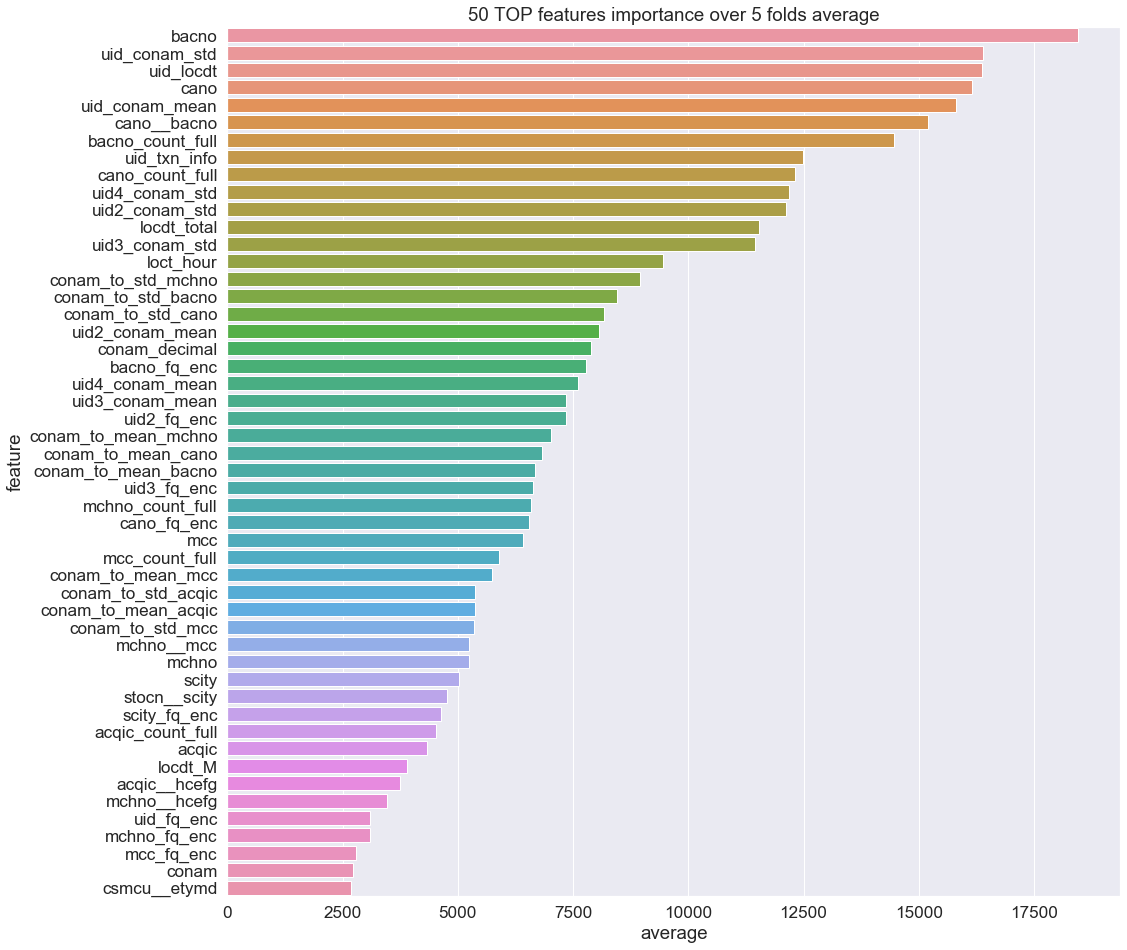

In [35]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('E-Sun_Credit_Card_Fraud_Detection_feature_importances_Kflod16.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP features importance over {} folds average'.format(folds.n_splits));

In [ ]:
(1/NFOLDS)*(NFOLDS/2)